## import base input targetlist

In [1]:
from astropy.io import ascii
from astropy.table import Table

# Load the target list
targetlist = ascii.read('Mtype_MetaData.csv')

print(targetlist.keys())

# Initialize the output table with the same columns as the target list
out_targetlist = Table(names=targetlist.colnames, dtype=[targetlist[col].dtype for col in targetlist.colnames])



['Star Name', 'Star Mass [Ms]', 'Star Temperature [K]', 'Star Radius [Rs]', 'Star Distance [pc]', 'Star K Mag', 'Star V Mag', 'Star Metallicity', 'Star Age [Gyr]', 'Star RA', 'Star Dec', 'Planet Name', 'Planet Period [days]', 'Planet Temperature [K]', 'Planet Semi-major Axis [m]', 'Planet Radius [Re]', 'Planet Albedo', 'Planet Mass [Me]', 'Molecular Weight', 'Transit Duration [s]', 'Impact Parameter', 'Heat Redistribution Factor', 'Inclination', 'Eccentricity', 'Transit Mid Time', 'Tier', 'Best Method', 'Time [s]', 'Chemistry filename', 'Temperature filename', 'COratio', 'OHratio', 'HeHratio', 'IceoverFe', 'Redox [Oxidized = 0, Reduced =1]']


## Load retrievals

In [2]:
import h5py
import os
import numpy as np
from tqdm import tqdm
from astropy.table import Table

# Retrieval folder
retrieval_folder = "./retrievals"

# Dictionary to track additional columns dynamically discovered in HDF5 files
additional_columns = {}

# First pass: Identify available data and new columns
valid_planets = []  # Store planets that have an HDF5 file

for i, planet in tqdm(enumerate(targetlist["Planet Name"]), total=len(targetlist)):
    path = os.path.join(retrieval_folder, planet)
    file = os.path.join(path, f"{planet}_retrieval.hdf5")

    if not os.path.exists(file):
        continue  # Skip planets without an associated file

    valid_planets.append(i)  # Store index of valid planets

    # Open the HDF5 file to discover new columns
    with h5py.File(file, 'r') as f:
        solution_path = "Output/Solutions/solution0/fit_params"
        if solution_path in f:
            additional_columns["H2/He"] = f["ModelParameters/Chemistry/ratio"][()].dtype
            for key in f[solution_path].keys():
                additional_columns[key] = f[f"{solution_path}/{key}/value"][()].dtype
                additional_columns[key+"_sigma_p"] = f[f"{solution_path}/{key}/sigma_p"][()].dtype
                additional_columns[key+"_sigma_m"] = f[f"{solution_path}/{key}/sigma_m"][()].dtype

# Initialize `out_targetlist` with only valid planets (ones that have a file)
out_targetlist = Table(
    names=targetlist.colnames, 
    dtype=[targetlist[col].dtype for col in targetlist.colnames]
)

# Ensure all additional columns exist in `out_targetlist`
for col_name, col_dtype in additional_columns.items():
    if col_name not in out_targetlist.colnames:
        if np.issubdtype(col_dtype, np.number):
            out_targetlist[col_name] = np.full(0, np.nan, dtype=col_dtype)
        else:
            out_targetlist[col_name] = np.full(0, "", dtype="U20")  # Default string length of 20

# Second pass: Extract data for valid planets and add them to `out_targetlist`
for i in tqdm(valid_planets, total=len(valid_planets)):
    planet = targetlist["Planet Name"][i]
    path = os.path.join(retrieval_folder, planet)
    file = os.path.join(path, f"{planet}_retrieval.hdf5")

    # Create a dictionary with the planet's existing metadata
    planet_data = {col: targetlist[i][col] for col in targetlist.colnames}

    # Open the HDF5 file
    with h5py.File(file, 'r') as f:
        solution_path = "Output/Solutions/solution0/fit_params"
        if solution_path in f:
            planet_data["H2/He"] = f["ModelParameters/Chemistry/ratio"][()]
            for key in f[solution_path].keys():
                planet_data[key] = f[f"{solution_path}/{key}/value"][()]
                planet_data[key+"_sigma_p"] = f[f"{solution_path}/{key}/sigma_p"][()]
                planet_data[key+"_sigma_m"] = f[f"{solution_path}/{key}/sigma_m"][()]

    # Ensure missing columns are filled with NaN or empty strings
    for col in out_targetlist.colnames:
        if col not in planet_data:
            if np.issubdtype(out_targetlist[col].dtype, np.integer):
                planet_data[col] = -1  # Assign a default integer value instead of NaN
            elif np.issubdtype(out_targetlist[col].dtype, np.number):
                planet_data[col] = np.nan  # Assign NaN for missing numerical values
            else:
                planet_data[col] = ""  # Assign empty string for missing text values

    # Add the row to `out_targetlist`
    out_targetlist.add_row([planet_data[col] for col in out_targetlist.colnames])

# Print final table length (should match number of valid planets)
print(len(out_targetlist))  # Should be <= len(targetlist), only including valid ones


100%|██████████| 54/54 [00:00<00:00, 193.13it/s]

54


## load Ariel's data

In [3]:
import astropy.units as u

# Ensure the required columns exist in out_targetlist
for col in ["nobs", "obs_time"]:
    if col not in out_targetlist.colnames:
        out_targetlist[col] = np.nan  # Initialize missing columns

forwards_folder = "./forwards/ArielInstrumentTier2"
for i, planet_data in tqdm(enumerate(out_targetlist), total=len(out_targetlist)):
    planet_dict = {col: planet_data[col] for col in out_targetlist.colnames}

    fname = os.path.join(forwards_folder, f"{planet_dict['Planet Name']}/{planet_dict['Planet Name']}.hdf5")
    if not os.path.isfile(fname):
        print("File not found:", planet_dict['Planet Name'])
        continue
    
    with h5py.File(fname, 'r') as f:
        ariel_path = f["Output/Spectra"]
        planet_dict["nobs"] = ariel_path["instrument_nobs"][()]
        planet_dict["obs_time"] = planet_dict['Transit Duration [s]'] * planet_dict["nobs"] * u.s.to(u.hr)

    # Ensure the row update follows the correct column order
    out_targetlist[i] = [planet_dict[col] for col in out_targetlist.colnames]


100%|██████████| 54/54 [00:00<00:00, 1227.55it/s]


## load profile data

In [4]:
comp_folders = ["/home/ariel/lorenzo.mugnai/USER_DATA/Alfnoor2/20250226 - NAOJ/first_week/M_type/CompoProfile_Oxidized",
                "/home/ariel/lorenzo.mugnai/USER_DATA/Alfnoor2/20250226 - NAOJ/first_week/M_type/CompoProfile_Reduced"]

pt_folders = ["/home/ariel/lorenzo.mugnai/USER_DATA/Alfnoor2/20250226 - NAOJ/first_week/M_type/PTProfile_Oxidized",
            "/home/ariel/lorenzo.mugnai/USER_DATA/Alfnoor2/20250226 - NAOJ/first_week/M_type/PTProfile_Reduced"]

for col in ["H2_profile", "He_profile", "H2O_profile", "CO_profile", "CO2_profile", "CH4_profile", "T_profile"]:
    if col not in out_targetlist.colnames:
        out_targetlist[col] = np.nan  # In

print(out_targetlist.colnames)

def find_file(path, keyword):
    file_list = os.listdir(path)
    # print(file_list)
    # print(planet_data['Planet Name'].split("_")[0])

    matching_files = [file for file in file_list if keyword in file]
    # print(matching_files)
    return matching_files

for i, planet_data in tqdm(enumerate(out_targetlist), total=len(out_targetlist)):

    planet_dict = {col: planet_data[col] for col in out_targetlist.colnames}

    matching_files =find_file(comp_folders[0], planet_data['Planet Name'].split("_")[0])
    if matching_files:
        fname = os.path.join(comp_folders[0], matching_files[0])
    else:
        matching_files =find_file(comp_folders[1], planet_data['Planet Name'].split("_")[0])
        if matching_files:
            fname = os.path.join(comp_folders[1], matching_files[0])
        else:
            continue
        
    data = ascii.read(fname, format='no_header', delimiter=' ')

    column_map = ["H2", "H2O", "CO", "CO2", "CH4", "He"]
    data.rename_columns(data.colnames, column_map)
    for column in column_map:
        planet_dict[f"{column}_profile"] = np.median(data[column])    
    
    matching_files =find_file(pt_folders[0], planet_data['Planet Name'].split("_")[0])
    if matching_files:
        fname = os.path.join(pt_folders[0], matching_files[0])
    else:
        matching_files =find_file(pt_folders[1], planet_data['Planet Name'].split("_")[0])
        if matching_files:
            fname = os.path.join(pt_folders[1], matching_files[0])
        else:
            continue
    data = ascii.read(fname, format='no_header', delimiter=' ')
    planet_dict[f"T_profile"] = np.median(data["col2"])

    # Ensure the row update follows the correct column order
    out_targetlist[i] = [planet_dict[col] for col in out_targetlist.colnames]



['Star Name', 'Star Mass [Ms]', 'Star Temperature [K]', 'Star Radius [Rs]', 'Star Distance [pc]', 'Star K Mag', 'Star V Mag', 'Star Metallicity', 'Star Age [Gyr]', 'Star RA', 'Star Dec', 'Planet Name', 'Planet Period [days]', 'Planet Temperature [K]', 'Planet Semi-major Axis [m]', 'Planet Radius [Re]', 'Planet Albedo', 'Planet Mass [Me]', 'Molecular Weight', 'Transit Duration [s]', 'Impact Parameter', 'Heat Redistribution Factor', 'Inclination', 'Eccentricity', 'Transit Mid Time', 'Tier', 'Best Method', 'Time [s]', 'Chemistry filename', 'Temperature filename', 'COratio', 'OHratio', 'HeHratio', 'IceoverFe', 'Redox [Oxidized = 0, Reduced =1]', 'H2/He', 'T', 'T_sigma_p', 'T_sigma_m', 'log_CH4', 'log_CH4_sigma_p', 'log_CH4_sigma_m', 'log_CO', 'log_CO_sigma_p', 'log_CO_sigma_m', 'log_CO2', 'log_CO2_sigma_p', 'log_CO2_sigma_m', 'log_H2O', 'log_H2O_sigma_p', 'log_H2O_sigma_m', 'planet_radius', 'planet_radius_sigma_p', 'planet_radius_sigma_m', 'nobs', 'obs_time', 'H2_profile', 'He_profile', 'H

100%|██████████| 54/54 [00:00<00:00, 249.40it/s]


## Compute metallicities

In [5]:
import sys
import os
import numpy as np
from tqdm import tqdm
from astropy.table import Table

# Add the current notebook's directory to the Python path
sys.path.append(os.getcwd())

# Now import the function
from mol_to_ratios import calculate_ratios_with_uncertainties

# Ensure the required columns exist in out_targetlist
for col in ["O/H", "O/H_sigma", "C/O", "C/O_sigma", "He/H", "He/H_sigma", 
            "He", "H2", "H2O", "CO", "CO2", "CH4", "H2O_sigma", "CO_sigma", "CO2_sigma", "CH4_sigma", "He_sigma", "H2_sigma", 
            "H", "C", "O", "H_sigma", "C_sigma", "O_sigma"]:
    if col not in out_targetlist.colnames:
        out_targetlist[col] = np.nan  # Initialize missing columns

# Iterate through each planet in the target list
for i, planet_data in tqdm(enumerate(out_targetlist), total=len(out_targetlist)):
    # Convert Row to a dictionary for easier modification
    planet_dict = {col: planet_data[col] for col in out_targetlist.colnames}

    # Retrieve molecular fractions and uncertainties from planet_dict
    try:
        ln10 = np.log(10)  # ln(10) ≈ 2.302

        H2O = 10**planet_dict.get("log_H2O", np.nan)
        CO = 10**planet_dict.get("log_CO", np.nan)
        CO2 = 10**planet_dict.get("log_CO2", np.nan)
        CH4 = 10**planet_dict.get("log_CH4", np.nan)

        sigma_H2O = ln10 * H2O * np.mean([planet_dict.get("log_H2O_sigma_p", np.nan), planet_dict.get("log_H2O_sigma_m", np.nan)])
        sigma_CO = ln10 * CO * np.mean([planet_dict.get("log_CO_sigma_p", np.nan), planet_dict.get("log_CO_sigma_m", np.nan)])
        sigma_CO2 = ln10 * CO2 * np.mean([planet_dict.get("log_CO2_sigma_p", np.nan), planet_dict.get("log_CO2_sigma_m", np.nan)])
        sigma_CH4 = ln10 * CH4 * np.mean([planet_dict.get("log_CH4_sigma_p", np.nan), planet_dict.get("log_CH4_sigma_m", np.nan)])

        planet_dict["H2O"] = H2O
        planet_dict["CO"] = CO
        planet_dict["CO2"] = CO2
        planet_dict["CH4"] = CH4
        planet_dict["H2O_sigma"] = sigma_H2O
        planet_dict["CO_sigma"] = sigma_CO
        planet_dict["CO2_sigma"] = sigma_CO2
        planet_dict["CH4_sigma"] = sigma_CH4
        
        # Retrieve precise H2/He ratio
        H2_He = planet_dict.get("H2/He", np.nan)

        # Compute elemental ratios
        ratios = calculate_ratios_with_uncertainties(H2_He, H2O, CO, CO2, CH4,
                                                    sigma_H2O, sigma_CO, 
                                                    sigma_CO2, sigma_CH4)

        # Add computed ratios to the planet dictionary
        planet_dict["O/H"] = ratios["O/H"][0]
        planet_dict["O/H_sigma"] = ratios["O/H"][1]
        planet_dict["C/O"] = ratios["C/O"][0]
        planet_dict["C/O_sigma"] = ratios["C/O"][1]
        planet_dict["He/H"] = ratios["He/H"][0]
        planet_dict["He/H_sigma"] = ratios["He/H"][1]
        planet_dict["He"] = ratios["He"][0]
        planet_dict["He_sigma"] = ratios["He"][1]
        planet_dict["H2"] = ratios["H2"][0]
        planet_dict["H2_sigma"] = ratios["H2"][1]
        planet_dict["H"] = ratios["H"][0]
        planet_dict["H_sigma"] = ratios["H"][1]
        planet_dict["C"] = ratios["C"][0]
        planet_dict["C_sigma"] = ratios["C"][1]
        planet_dict["O"] = ratios["O"][0]
        planet_dict["O_sigma"] = ratios["O"][1]

    except KeyError:
        pass  # If any key is missing, skip adding ratios

    # Ensure missing columns are set to NaN
    for col in out_targetlist.colnames:
        if col not in planet_dict:
            planet_dict[col] = np.nan

    # Ensure the row update follows the correct column order
    out_targetlist[i] = [planet_dict[col] for col in out_targetlist.colnames]
    
# Ensure the required columns exist in out_targetlist
for col in ["O/H_profile", "C/O_profile", "He/H_profile", "He_profile", "H2_profile", "H_profile", "C_profile", "O_profile"]:
    if col not in out_targetlist.colnames:
        out_targetlist[col] = np.nan  # Initialize missing columns

# Iterate through each planet in the target list
for i, planet_data in tqdm(enumerate(out_targetlist), total=len(out_targetlist)):
    # Convert Row to a dictionary for easier modification
    planet_dict = {col: planet_data[col] for col in out_targetlist.colnames}

    # Retrieve molecular fractions and uncertainties from planet_dict
    H2O = planet_dict.get("H2O_profile", np.nan)
    CO = planet_dict.get("CO_profile", np.nan)
    CO2 = planet_dict.get("CO2_profile", np.nan)
    CH4 = planet_dict.get("CH4_profile", np.nan)
    H2_He = 1e-100
    
    ratios = calculate_ratios_with_uncertainties(H2_He, H2O, CO, CO2, CH4)

    # Add computed ratios to the planet dictionary
    planet_dict["O/H_profile"] = ratios["O/H"]
    planet_dict["C/O_profile"] = ratios["C/O"]
    planet_dict["He/H_profile"] = ratios["He/H"]
    planet_dict["He_profile"] = ratios["He"]
    planet_dict["H2_profile"] = ratios["H2"]
    planet_dict["H_profile"] = ratios["H"]
    planet_dict["C_profile"] = ratios["C"]
    planet_dict["O_profile"] = ratios["O"]
    out_targetlist[i] = [planet_dict[col] for col in out_targetlist.colnames]





100%|██████████| 54/54 [00:00<00:00, 3276.75it/s]


## saving data

In [16]:
print(out_targetlist.keys())
ascii.write(out_targetlist, 'Mtype_MetaData_analyzed.csv', format='csv', overwrite=True)

['Star Name', 'Star Mass [Ms]', 'Star Temperature [K]', 'Star Radius [Rs]', 'Star Distance [pc]', 'Star K Mag', 'Star V Mag', 'Star Metallicity', 'Star Age [Gyr]', 'Star RA', 'Star Dec', 'Planet Name', 'Planet Period [days]', 'Planet Temperature [K]', 'Planet Semi-major Axis [m]', 'Planet Radius [Re]', 'Planet Albedo', 'Planet Mass [Me]', 'Molecular Weight', 'Transit Duration [s]', 'Impact Parameter', 'Heat Redistribution Factor', 'Inclination', 'Eccentricity', 'Transit Mid Time', 'Tier', 'Best Method', 'Time [s]', 'Chemistry filename', 'Temperature filename', 'COratio', 'OHratio', 'HeHratio', 'IceoverFe', 'Redox [Oxidized = 0, Reduced =1]', 'H2/He', 'T', 'T_sigma_p', 'T_sigma_m', 'log_CH4', 'log_CH4_sigma_p', 'log_CH4_sigma_m', 'log_CO', 'log_CO_sigma_p', 'log_CO_sigma_m', 'log_CO2', 'log_CO2_sigma_p', 'log_CO2_sigma_m', 'log_H2O', 'log_H2O_sigma_p', 'log_H2O_sigma_m', 'planet_radius', 'planet_radius_sigma_p', 'planet_radius_sigma_m', 'nobs', 'obs_time', 'H2_profile', 'He_profile', 'H

# let's make some sense of the data

In [7]:
from astropy.table import Table
import pandas as pd
from IPython.display import display

df = out_targetlist.to_pandas()  


display(df[["O/H", "O/H_sigma", "C/O", "C/O_sigma", "He/H", "He/H_sigma", "H2O", "H2O_sigma","CO",  "CO_sigma", "CO2", "CO2_sigma","CH4",  "CH4_sigma", "H2_profile", "He_profile", "H2O_profile", "CO_profile", "CO2_profile", "CH4_profile", "T_profile"]])


display(df[["O/H", "O/H_sigma", "C/O", "C/O_sigma", "He/H", "He/H_sigma", "O/H_profile", "C/O_profile", "He/H_profile", "OHratio", "COratio", "HeHratio"]])


display(df[["Planet Temperature [K]", "T_profile", "T", "T_sigma_p"]])


,O/H,O/H_sigma,C/O,C/O_sigma,He/H,He/H_sigma,H2O,H2O_sigma,CO,CO_sigma,...,CO2_sigma,CH4,CH4_sigma,H2_profile,He_profile,H2O_profile,CO_profile,CO2_profile,CH4_profile,T_profile
0,0.147822,0.020733,0.008378,0.002178,1.712206e-100,1.317521e-101,0.296378,0.038351,8.140191e-08,3.732644e-07,...,4.163352e-08,0.002483,0.000560,0.765037,7.650367e-101,0.232936,1.164578e-27,6.050212e-24,0.002027,417.187941
1,0.169584,0.026478,0.006866,0.002067,1.606382e-100,1.594814e-101,0.339959,0.047857,5.710066e-08,2.692376e-07,...,5.408865e-09,0.002334,0.000621,0.724427,7.244269e-101,0.271956,2.055376e-24,4.014154e-21,0.003617,452.887658
2,0.118042,0.019554,0.010757,0.004611,1.859572e-100,1.332948e-101,0.236310,0.037161,2.541539e-04,8.765397e-04,...,6.768789e-09,0.002291,0.000512,0.862163,8.621630e-101,0.136731,7.325353e-31,5.783401e-27,0.001106,399.809567
3,0.122370,0.020602,0.007189,0.002141,1.840341e-100,1.391419e-101,0.245170,0.039006,1.198232e-07,5.832320e-07,...,6.233222e-08,0.001762,0.000444,0.863022,8.630220e-101,0.134717,4.802580e-28,1.309070e-24,0.002261,446.503070
4,0.094447,0.014035,0.009324,0.002540,1.977046e-100,1.008014e-101,0.189227,0.027167,5.020455e-08,2.259504e-07,...,1.590926e-07,0.001764,0.000409,0.742625,7.426247e-101,0.252489,6.944969e-20,1.949854e-17,0.004886,530.155432
5,0.124730,0.021102,0.007848,0.002603,1.827811e-100,1.417154e-101,0.249949,0.039876,2.174209e-08,8.853273e-08,...,7.384668e-09,0.001962,0.000570,0.937459,9.374590e-101,0.061813,5.043312e-31,1.357584e-27,0.000728,406.356284
6,0.094915,0.020743,0.007665,0.002660,1.976255e-100,1.488819e-101,0.190106,0.040126,9.775453e-08,4.484019e-07,...,1.430198e-08,0.001457,0.000401,0.933161,9.331608e-101,0.065892,1.358656e-29,2.285352e-26,0.000947,415.011544
7,0.153257,0.019750,0.005533,0.001617,1.689427e-100,1.239879e-101,0.307033,0.036302,9.567231e-07,5.797581e-06,...,1.250622e-08,0.001698,0.000454,0.817768,8.177685e-101,0.179895,6.186010e-17,2.642834e-15,0.002336,613.169230
8,0.112762,0.014683,0.007846,0.001872,1.887334e-100,1.013408e-101,0.225923,0.028026,4.980402e-08,2.242861e-07,...,4.205335e-09,0.001773,0.000361,0.703789,7.037891e-101,0.293487,2.336129e-22,2.120699e-19,0.002724,486.658599
9,0.090913,0.020763,0.012037,0.004259,1.992254e-100,1.501406e-101,0.182226,0.040305,4.039622e-08,1.780708e-07,...,1.375501e-08,0.002193,0.000606,0.771389,7.713885e-101,0.224982,3.569643e-28,2.445662e-24,0.003629,392.904668


,O/H,O/H_sigma,C/O,C/O_sigma,He/H,He/H_sigma,O/H_profile,C/O_profile,He/H_profile,OHratio,COratio,HeHratio
0,0.147822,0.020733,0.008378,0.002178,1.712206e-100,1.317521e-101,0.116232,0.008704,3.817444e-101,0.116232,0.008704,0
1,0.169584,0.026478,0.006866,0.002067,1.606382e-100,1.594814e-101,0.135488,0.013302,3.609079e-101,0.135488,0.013302,0
2,0.118042,0.019554,0.010757,0.004611,1.859572e-100,1.332948e-101,0.068290,0.008086,4.306054e-101,0.068290,0.008086,0
3,0.122370,0.020602,0.007189,0.002141,1.840341e-100,1.391419e-101,0.067207,0.016783,4.305376e-101,0.067207,0.016783,0
4,0.094447,0.014035,0.009324,0.002540,1.977046e-100,1.008014e-101,0.125631,0.019353,3.695068e-101,0.125631,0.019353,0
5,0.124730,0.021102,0.007848,0.002603,1.827811e-100,1.417154e-101,0.030884,0.011783,4.683884e-101,0.030884,0.011783,0
6,0.094915,0.020743,0.007665,0.002660,1.976255e-100,1.488819e-101,0.032915,0.014373,4.661389e-101,0.032915,0.014373,0
7,0.153257,0.019750,0.005533,0.001617,1.689427e-100,1.239879e-101,0.089738,0.012986,4.079313e-101,0.089738,0.012986,0
8,0.112762,0.014683,0.007846,0.001872,1.887334e-100,1.013408e-101,0.146345,0.009281,3.509387e-101,0.146345,0.009281,0
9,0.090913,0.020763,0.012037,0.004259,1.992254e-100,1.501406e-101,0.112084,0.016132,3.842995e-101,0.112084,0.016132,0


,Planet Temperature [K],T_profile,T,T_sigma_p
0,324.497,417.187941,386.713844,29.164318
1,353.474,452.887658,411.827678,38.612165
2,303.566,399.809567,315.216495,27.473419
3,325.772,446.503070,326.804602,32.825734
4,411.151,530.155432,385.151452,25.264463
5,307.223,406.356284,299.341058,28.300536
6,317.529,415.011544,290.935409,34.550922
7,471.722,613.169230,521.122448,35.726392
8,378.733,486.658599,392.638292,25.183422
9,320.182,392.904668,280.883255,31.203747


# Let's do some plotting now

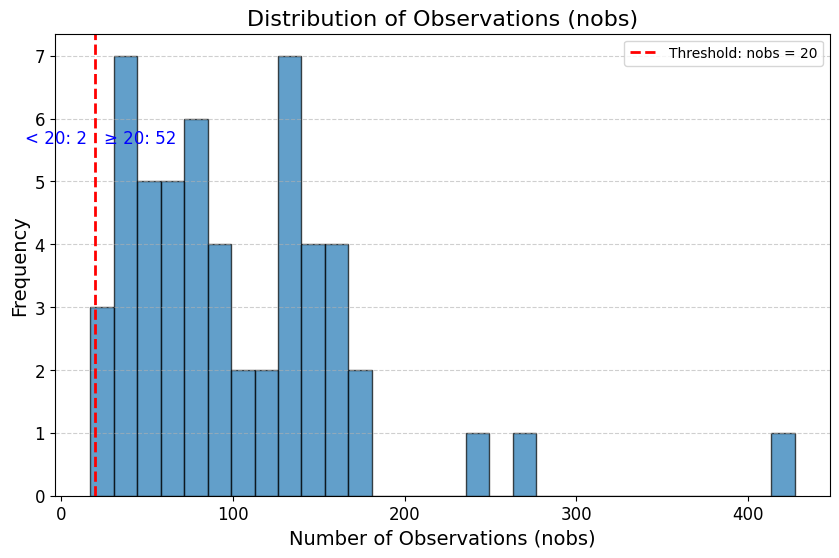

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Extract data for the histogram
nobs_data = np.array(out_targetlist["nobs"])

# Define binning for more granularity
bins = 30  

# Create the figure and axis
plt.figure(figsize=(10, 6))

# Plot histogram
counts, bin_edges, _ = plt.hist(nobs_data, bins=bins, edgecolor="black", alpha=0.7)

# Add a vertical line at nobs = 20
plt.axvline(x=20, color="red", linestyle="--", linewidth=2, label="Threshold: nobs = 20")

# Count elements before and after nobs = 20
below_threshold = np.sum(nobs_data < 20)
above_threshold = np.sum(nobs_data >= 20)

# Annotate the counts
plt.text(15, max(counts) * 0.8, f"< 20: {below_threshold}", color="blue", fontsize=12, ha="right")
plt.text(25, max(counts) * 0.8, f"≥ 20: {above_threshold}", color="blue", fontsize=12, ha="left")

# Labels and title
plt.xlabel("Number of Observations (nobs)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("Distribution of Observations (nobs)", fontsize=16)

# Improve readability
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.legend()

# Show the plot
plt.show()



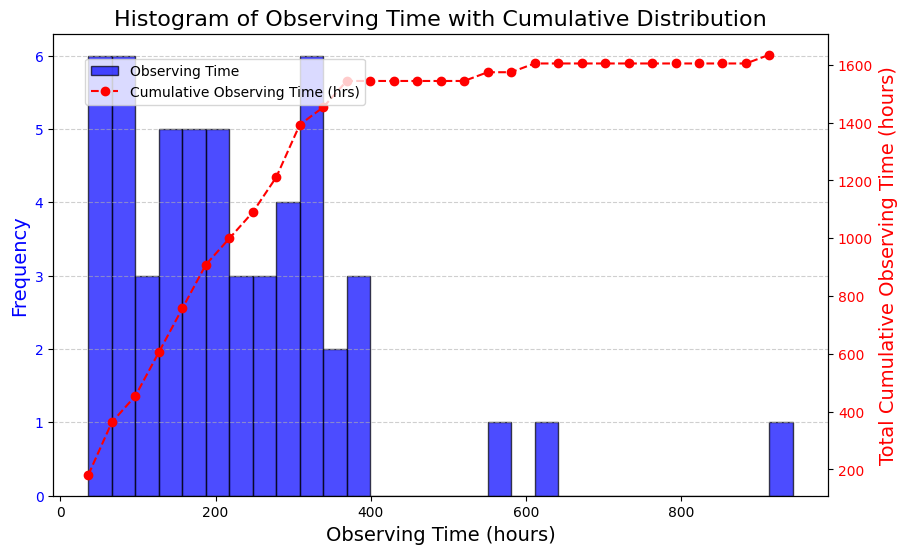

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Extract data for the histogram
obs_time_data = np.array(out_targetlist["obs_time"])  # Replace with correct column name if different

# Define binning
bins = 30  

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot histogram
counts, bin_edges, _ = ax1.hist(obs_time_data, bins=bins, edgecolor="black", alpha=0.7, label="Observing Time", color="blue")

# Compute cumulative distribution
cumulative_hours = np.cumsum(counts * np.diff(bin_edges))  # Multiply bin count by bin width to get total hours

# Create second Y-axis for cumulative curve
ax2 = ax1.twinx()
ax2.plot(bin_edges[:-1], cumulative_hours, color="red", linestyle="--", marker="o", label="Cumulative Observing Time (hrs)")

# Labels and title
ax1.set_xlabel("Observing Time (hours)", fontsize=14)
ax1.set_ylabel("Frequency", fontsize=14, color="blue")
ax2.set_ylabel("Total Cumulative Observing Time (hours)", fontsize=14, color="red")
plt.title("Histogram of Observing Time with Cumulative Distribution", fontsize=16)

# Improve readability
ax1.tick_params(axis="y", labelcolor="blue")
ax2.tick_params(axis="y", labelcolor="red")
ax1.grid(axis="y", linestyle="--", alpha=0.6)

# Legend
fig.legend(loc="upper left", bbox_to_anchor=(0.15, 0.85))

# Show the plot
plt.show()


## validate retrieval

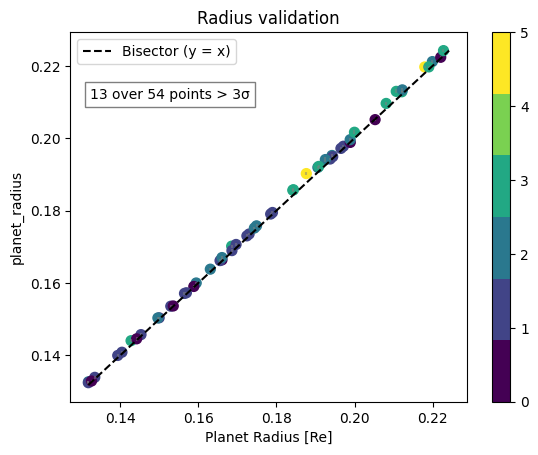

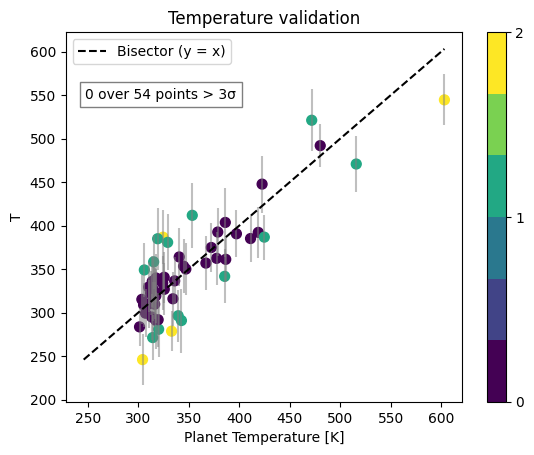

In [39]:
import matplotlib.pyplot as plt
import numpy as np

def plot_comparison(data, x_col, y_col, y_err_plus_col, y_err_minus_col, conversion_factor=None, title=None):
    """
    Plot a comparison between two columns (x and y) with error bars and a quantised colour bar.
    
    Parameters:
    - data: dictionary-like object (e.g. pandas DataFrame) containing the columns.
    - x_col: string, name of the x-axis column.
    - y_col: string, name of the y-axis column.
    - y_err_plus_col: string, name of the column with the positive error for y.
    - y_err_minus_col: string, name of the column with the negative error for y.
    - conversion_factor: optional; if provided, x values will be multiplied by this factor.
    """
    # Retrieve x values and apply conversion if needed.
    if conversion_factor is not None:
        x_values = data[x_col] * conversion_factor
    else:
        x_values = data[x_col]
    
    # Retrieve y values.
    y_values = data[y_col]
    
    # Compute the symmetric y error as the mean of the positive and negative errors.
    y_error = np.mean([data[y_err_plus_col], data[y_err_minus_col]], axis=0)
    
    # Compute the sigma difference from the bisector (y = x)
    sigma_diff = (y_values - x_values) / y_error
    
    # Count the number of points with an absolute sigma difference greater than 3.
    num_over3 = np.sum(np.abs(sigma_diff) > 3)
    
    # Quantise the sigma difference: floor the absolute value and cap at 5.
    quant_sigma = np.clip(np.floor(np.abs(sigma_diff)), 0, 5)
    
    # Create a discrete colormap with 6 bins (0, 1, 2, 3, 4, 5).
    cmap = plt.get_cmap('viridis', 6)
    
    fig, ax = plt.subplots()
    
    if title is not None:
        plt.title(title)
    # Plot the error bars in grey.
    ax.errorbar(x_values, y_values, yerr=y_error, fmt='none', color='grey', alpha=0.5)
    
    # Plot the scatter points, coloured by the quantised sigma difference.
    sc = ax.scatter(x_values, y_values, c=quant_sigma, cmap=cmap, s=50)
    
    # Define limits for the bisector line.
    min_val = min(np.min(x_values), np.min(y_values))
    max_val = max(np.max(x_values), np.max(y_values))
    
    # Plot the bisector line (y = x).
    ax.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='black', label='Bisector (y = x)')
    
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.legend()
    
    # Add an annotation indicating the number of points beyond 3σ.
    ax.annotate(f'{num_over3} over {len(x_values)} points > 3σ', xy=(0.05, 0.85), xycoords='axes fraction',
                ha='left', va='top', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))
    
    # Create a quantised colourbar.
    cbar = plt.colorbar(sc, ax=ax, ticks=range(6))
    plt.show()

# Esempio di utilizzo:
plot_comparison(out_targetlist, 'Planet Radius [Re]', 'planet_radius', 'planet_radius_sigma_p', 'planet_radius_sigma_m', title="Radius validation", conversion_factor=u.R_earth.to(u.R_jup))

plot_comparison(out_targetlist, 'Planet Temperature [K]', 'T', 'T_sigma_p', 'T_sigma_m', title="Temperature validation")


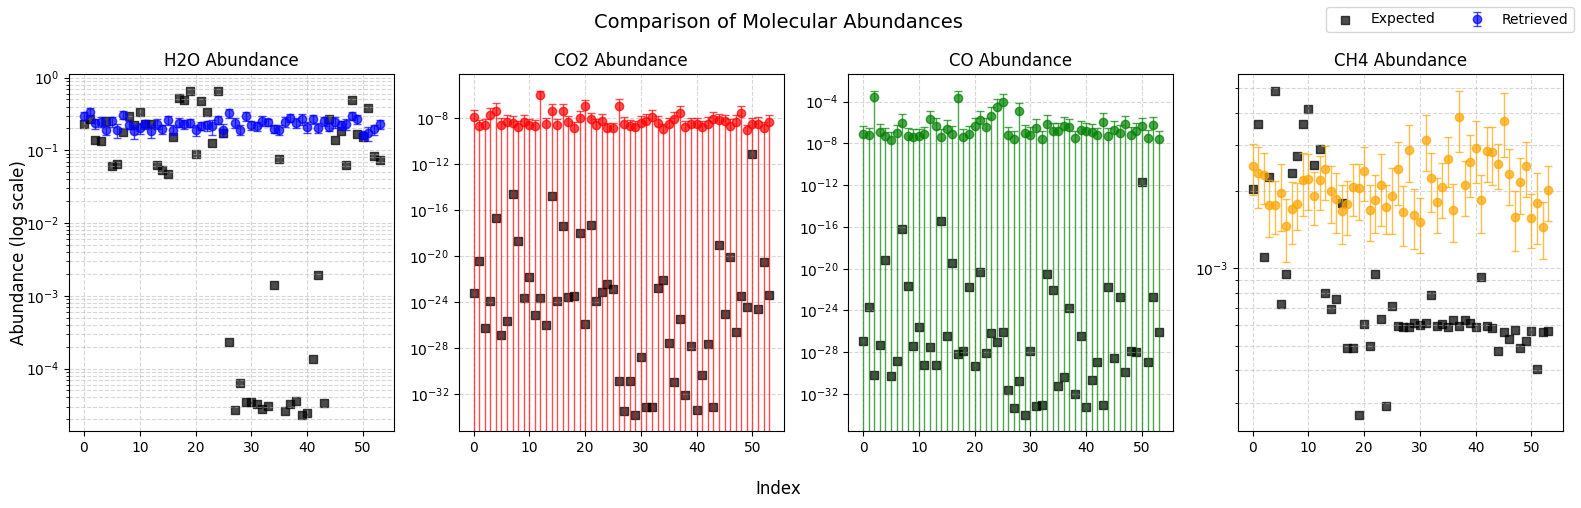

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define molecules and corresponding colors for consistency
molecules = ["H2O", "CO2", "CO", "CH4"]
colors = ["blue", "red", "green", "orange"]  # Assign unique colors to each molecule

# Create a figure with 4 subplots (one for each molecule)
fig, axes = plt.subplots(1, 4, figsize=(16, 5), sharex=True, sharey=False)  # Share x and y axes for better comparison

for ax, mol, color in zip(axes, molecules, colors):
    # Observed values with error bars (dotted)
    ax.errorbar(np.arange(len(out_targetlist)), out_targetlist[mol], 
                yerr=out_targetlist[f"{mol}_sigma"], fmt="o", color=color, alpha=0.7,
                capsize=3, capthick=1, elinewidth=1, label="Retrieved")
    
    # Expected values without error bars
    ax.scatter(np.arange(len(out_targetlist)), out_targetlist[colorf"{mol}_profile"], 
               label="Expected", color="k", marker="s", alpha=0.7)

    # Set log scale for y-axis
    ax.set_yscale("log")

    # Set title for each molecule
    ax.set_title(f"{mol} Abundance", fontsize=12)

    # Enable grid for better readability
    ax.grid(True, which="both", linestyle="--", alpha=0.5)

# Common labels
fig.suptitle("Comparison of Molecular Abundances", fontsize=14)
fig.supxlabel("Index")
fig.supylabel("Abundance (log scale)")

# Add a single legend outside the plots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right", fontsize=10, ncol=2)

# Improve layout
plt.tight_layout()
plt.show()


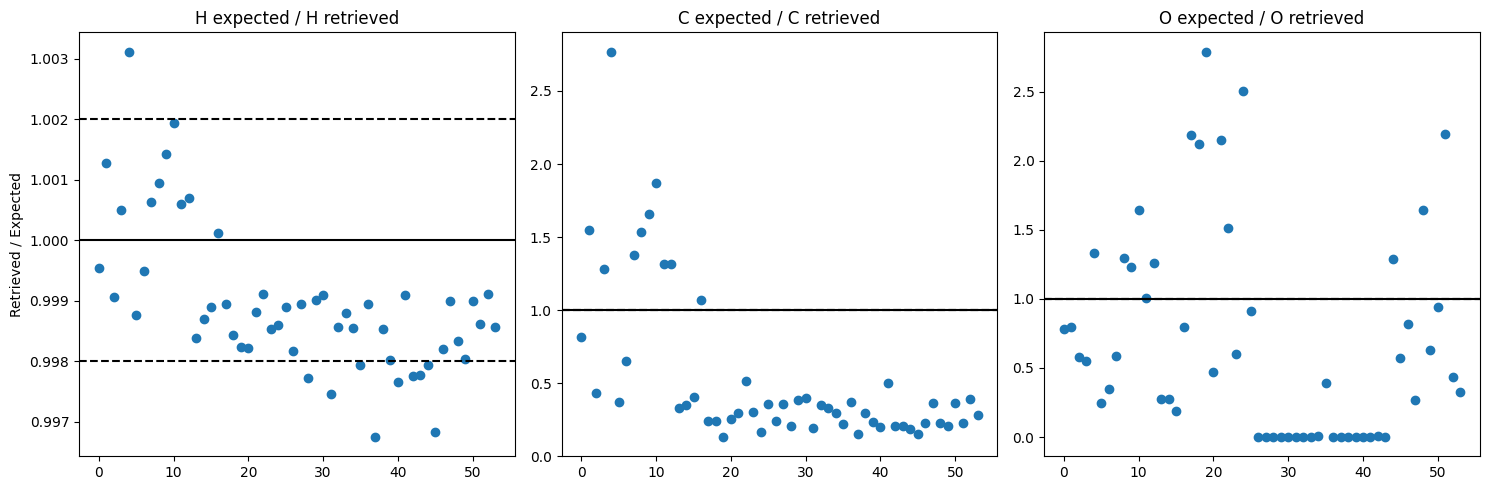

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Creazione della figura con 3 pannelli orizzontali (1 riga, 3 colonne)
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False)  # Condivide l'asse y

# Lista degli elementi da plottare
elements = ["H", "C", "O"]
titles = ["H expected / H retrieved", "C expected / C retrieved", "O expected / O retrieved"]

for i, element in enumerate(elements):
    ax = axes[i]  # Seleziona l'asse corrente
    ax.scatter(np.arange(len(out_targetlist)), out_targetlist[f"{element}_profile"] / out_targetlist[element])
    
    # Linee guida
    ax.axhline(1, c="k")
    ax.axhline(1.002, c="k", ls="--")
    ax.axhline(0.998, c="k", ls="--")

    ax.set_title(titles[i])  # Titolo per ogni subplot

# Etichetta asse y comune
axes[0].set_ylabel("Retrieved / Expected")

# Migliora layout per evitare sovrapposizioni
plt.tight_layout()
plt.show()



In [88]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator

def plot_scatter_with_histograms(
    data_table, x_key, y_key,
    x_err_key=None, y_err_key=None, color_key=None,
    cmap="viridis", hist_color="black", bins_num=30, marker="o",
    ax_scatter=None, ax_hist_x=None, ax_hist_y=None, ax_legend=None, fig=None,
    label=None, alpha=0.6, 
    err_color="black", elinewidth=1.5, capsize=3, capthick=1, errorevery=1, err_alpha=0.5, linestyle="-",
    global_norm=None
):
    """
    Creates or updates a scatter plot with histograms projected on the x and y axes.
    
    If axes are provided, it overlays new data on the existing plots.
    
    Parameters:
    - data_table: astropy.table.Table
        Table containing the data.
    - x_key, y_key: str
        Column names for the x and y axes.
    - x_err_key, y_err_key: str (optional)
        Column names for error bars (if available).
    - color_key: str (optional)
        Column name for data point color (if available).
    - cmap: str
        Colormap for scatter plot points.
    - hist_color: str
        Color for histograms.
    - bins_num: int
        Number of bins for histograms.
    - marker: str
        Shape of data points in scatter plot.
    - ax_scatter, ax_hist_x, ax_hist_y: matplotlib.axes.Axes
        Pre-existing axes to overlay new data. If None, new figures are created.
    - ax_legend: matplotlib.axes.Axes
        Axis for the legend (to be placed in the empty space).
    - fig: matplotlib.figure.Figure
        Pre-existing figure to overlay new data. If None, new figures are created.
    - label: str
        Label for the dataset (for legend).
    - alpha: float
        Transparency of the scatter points.
    - err_color: str
        Color of the error bars.
    - elinewidth: float
        Line width of the error bars.
    - capsize: float
        Size of the caps on the error bars.
    - capthick: float
        Thickness of the caps on the error bars.
    - errorevery: int
        Plot error bars only for every N-th point to improve readability.
    - linestyle: str
        Line style for the error bars.
    - err_alpha: float
        Transparency of the error bars.
    - global_norm: matplotlib.colors.Normalize
        Normalization object shared between all datasets.
        
    Returns:
    - ax_scatter, ax_hist_x, ax_hist_y, ax_legend: matplotlib.axes.Axes
        Axes for reuse in additional plots.
    """

    # Extract data
    x_data = np.array(data_table[x_key])
    y_data = np.array(data_table[y_key])
    x_err = np.array(data_table[x_err_key]) if x_err_key else None
    y_err = np.array(data_table[y_err_key]) if y_err_key else None
    color_data = np.array(data_table[color_key]) if color_key else None

    # Create global norm if first plot
    if global_norm is None and color_key is not None:
        global_norm = plt.Normalize(vmin=np.nanmin(color_data), vmax=np.nanmax(color_data))

    # Normalize color data
    cmap_instance = plt.cm.get_cmap(cmap)


    # Create new figure and axes if not provided
    new_plot = False
    if ax_scatter is None or ax_hist_x is None or ax_hist_y is None:
        new_plot = True
        fig = plt.figure(figsize=(10, 8))
        gs = fig.add_gridspec(4, 5, hspace=0, wspace=0.1, width_ratios=[1, 1, 1, 1, 0.3])

        ax_scatter = fig.add_subplot(gs[1:4, 0:3])  # Main scatter plot
        ax_hist_x = fig.add_subplot(gs[0, 0:3], sharex=ax_scatter)  # X histogram
        ax_hist_y = fig.add_subplot(gs[1:4, 3], sharey=ax_scatter)  # Y histogram
        ax_legend = fig.add_subplot(gs[0, 3:5])  # Legend area
        ax_legend.axis("off")  # Hide axis
        if color_key is not None:
            ax_colorbar = fig.add_subplot(gs[1:4, 4])  # Colorbar axis

    # Scatter plot
    scatter = ax_scatter.scatter(
        x_data, y_data, c=color_data, cmap=cmap, norm=global_norm,
        alpha=alpha, edgecolors="None", label=label, marker=marker, zorder=100
    )

    # Error bars with customization options
    if x_err is not None or y_err is not None:
        for i in range(0, len(x_data), errorevery):  # Apply errorevery filter
            ax_scatter.errorbar(
                x_data[i], y_data[i],
                xerr=x_err[i] if x_err is not None else None,
                yerr=y_err[i] if y_err is not None else None,
                alpha=err_alpha, fmt="o", color=cmap_instance(global_norm(color_data[i])) if color_data is not None else "black",
                ecolor = err_color, elinewidth=elinewidth, capsize=capsize, capthick=capthick, linestyle=linestyle, zorder=1
            )

    # Define log-spaced bins for x-axis histogram
    bins_x = np.logspace(np.log10(np.nanmin(x_data)), np.log10(np.nanmax(x_data)), bins_num)
    ax_hist_x.hist(x_data, bins=bins_x, edgecolor="black", alpha=0.7, label=label, color=hist_color)

    # Define log-spaced bins for y-axis histogram
    bins_y = np.logspace(np.log10(np.nanmin(y_data)), np.log10(np.nanmax(y_data)), bins_num)
    ax_hist_y.hist(y_data, bins=bins_y, orientation="horizontal", edgecolor="black", alpha=0.7, label=label, color=hist_color)

    # Ensure natural number frequencies
    ax_hist_x.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax_hist_y.xaxis.set_major_locator(MaxNLocator(integer=True))

    # Labels and title (only for the first plot)
    if new_plot:
        ax_scatter.set_xlabel(x_key, fontsize=14)
        ax_scatter.set_ylabel(y_key, fontsize=14)
        ax_scatter.set_title(f"Scatter Plot of {x_key} vs {y_key}", fontsize=16)

        ax_scatter.set_xscale("log")
        ax_scatter.set_yscale("log")

        # Hide labels on histograms
        plt.setp(ax_hist_x.get_xticklabels(), visible=False)
        plt.setp(ax_hist_y.get_yticklabels(), visible=False)

        # Grid
        ax_scatter.grid(True, linestyle="--", alpha=0.6)

        # # Legend (if label is provided)
        # if label:
        #     ax_scatter.legend()
            
            # Colorbar (only for the first dataset)
        if color_key is not None:

            cbar = plt.colorbar(scatter, cax=ax_colorbar)
            cbar.set_label(color_key, fontsize=12)

    # Histogram Legend (only if more than one dataset is present)
    if not new_plot:
        handles_scatter, labels_scatter = ax_scatter.get_legend_handles_labels()
        handles_hist_x, labels_hist_x = ax_hist_x.get_legend_handles_labels()
        
        # Merge legend entries
        handles = handles_scatter + handles_hist_x
        labels = labels_scatter + labels_hist_x
        
        if len(labels) > 1:  # Only show legend if there are multiple datasets
            ax_legend.legend(handles, labels, loc="upper right", frameon=False)

    return fig, ax_scatter, ax_hist_x, ax_hist_y, ax_legend, global_norm


/tmp/ipykernel_2877269/4215962026.py:80: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_instance = plt.cm.get_cmap(cmap)
/tmp/ipykernel_2877269/4215962026.py:99: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax_scatter.scatter(


Text(0.5, 0.98, 'Input values')

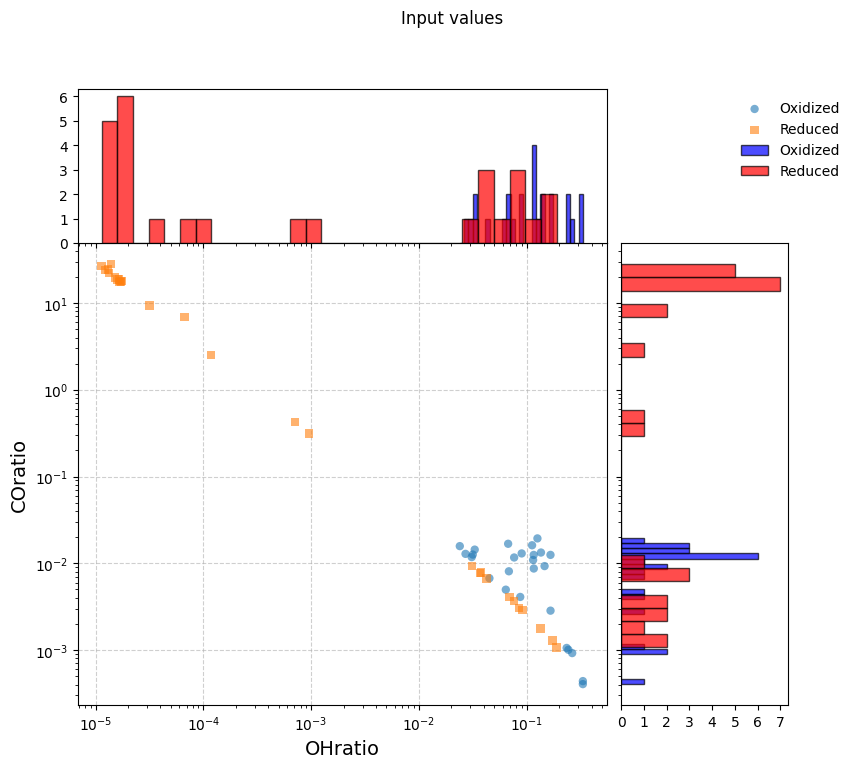

In [89]:
# plot_scatter_with_histograms(out_targetlist[out_targetlist["Redox [Oxidized = 0, Reduced =1]"]==0], "COratio", "OHratio")
# plot_scatter_with_histograms(out_targetlist, "COratio", "OHratio")

fig, ax_s, ax_hx, ax_hy, ax_leg, global_norm = plot_scatter_with_histograms(
    out_targetlist[out_targetlist["Redox [Oxidized = 0, Reduced =1]"]==0], "OHratio", "COratio",
    label="Oxidized", marker="o", cmap="Blues", hist_color="blue"
)

plot_scatter_with_histograms(
    out_targetlist[out_targetlist["Redox [Oxidized = 0, Reduced =1]"]==1], "OHratio", "COratio",
    label="Reduced", marker="s", cmap="Reds", hist_color="red",
    ax_scatter=ax_s, ax_hist_x=ax_hx, ax_hist_y=ax_hy, ax_legend=ax_leg, fig=fig, global_norm=global_norm
)

fig.suptitle("Input values")

In [13]:
# # plot_scatter_with_histograms(out_targetlist, "C/O", "O/H")

# # plot_scatter_with_histograms(out_targetlist[out_targetlist["Redox [Oxidized = 0, Reduced =1]"]==1], "C/O", "O/H", x_err_key="C/O_sigma", y_err_key="O/H_sigma", color_key="He/H")
# plot_scatter_with_histograms(out_targetlist, "C/O", "O/H", x_err_key="C/O_sigma", y_err_key="O/H_sigma", color_key="He/H")

# plot_scatter_with_histograms(out_targetlist[out_targetlist["Redox [Oxidized = 0, Reduced =1]"]==0], "C/O", "O/H", x_err_key="C/O_sigma", y_err_key="O/H_sigma", color_key="Planet Semi-major Axis [m]")
# plot_scatter_with_histograms(out_targetlist[out_targetlist["Redox [Oxidized = 0, Reduced =1]"]==1], "C/O", "O/H", x_err_key="C/O_sigma", y_err_key="O/H_sigma", color_key="Planet Semi-major Axis [m]")



/tmp/ipykernel_2877269/4215962026.py:80: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_instance = plt.cm.get_cmap(cmap)
/tmp/ipykernel_2877269/4215962026.py:99: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax_scatter.scatter(


Text(0.5, 0.98, 'Retrievals compared')

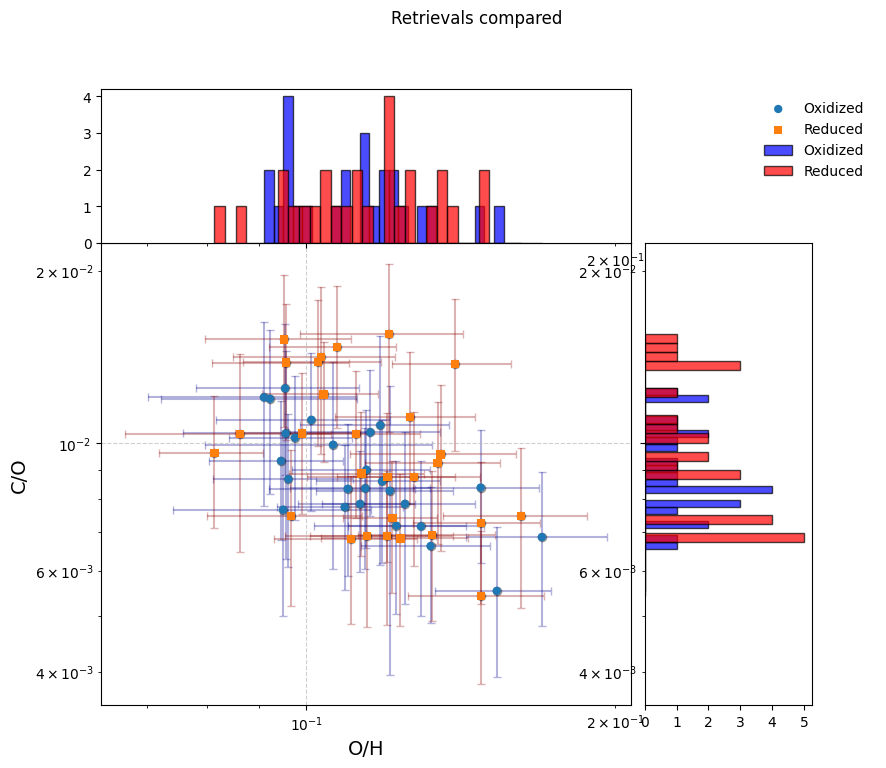

In [90]:
fig, ax_s, ax_hx, ax_hy, ax_leg, global_norm = plot_scatter_with_histograms(
    out_targetlist[out_targetlist["Redox [Oxidized = 0, Reduced =1]"]==0], 
    x_key="O/H", y_key="C/O", 
    x_err_key="O/H_sigma", y_err_key="C/O_sigma", 
    # color_key="He/H", 
    label="Oxidized", marker="o", cmap="viridis", hist_color="blue", alpha=1,
    err_color="darkblue", elinewidth=1.5, capsize=3, capthick=1, errorevery=1, err_alpha=0.3
)

plot_scatter_with_histograms(
    out_targetlist[out_targetlist["Redox [Oxidized = 0, Reduced =1]"]==1], 
    x_key="O/H", y_key="C/O", 
    x_err_key="O/H_sigma", y_err_key="C/O_sigma", 
    # color_key="He/H", 
    label="Reduced", marker="s", cmap="viridis", hist_color="red", alpha=1,
    err_color="darkred", elinewidth=1.5, capsize=3, capthick=1, errorevery=1, err_alpha=0.3,
    ax_scatter=ax_s, ax_hist_x=ax_hx, ax_hist_y=ax_hy, ax_legend=ax_leg, global_norm=global_norm, fig=fig)

fig.suptitle("Retrievals compared")

/tmp/ipykernel_2877269/2725468580.py:80: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_instance = plt.cm.get_cmap(cmap)


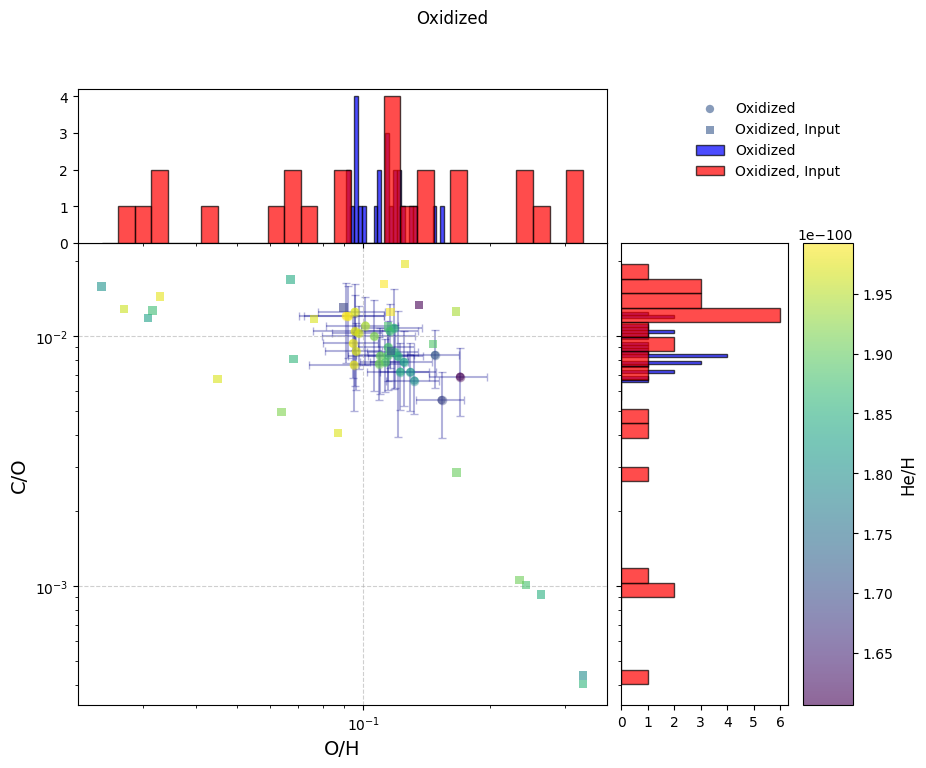

Text(0.5, 0.98, 'Reduced')

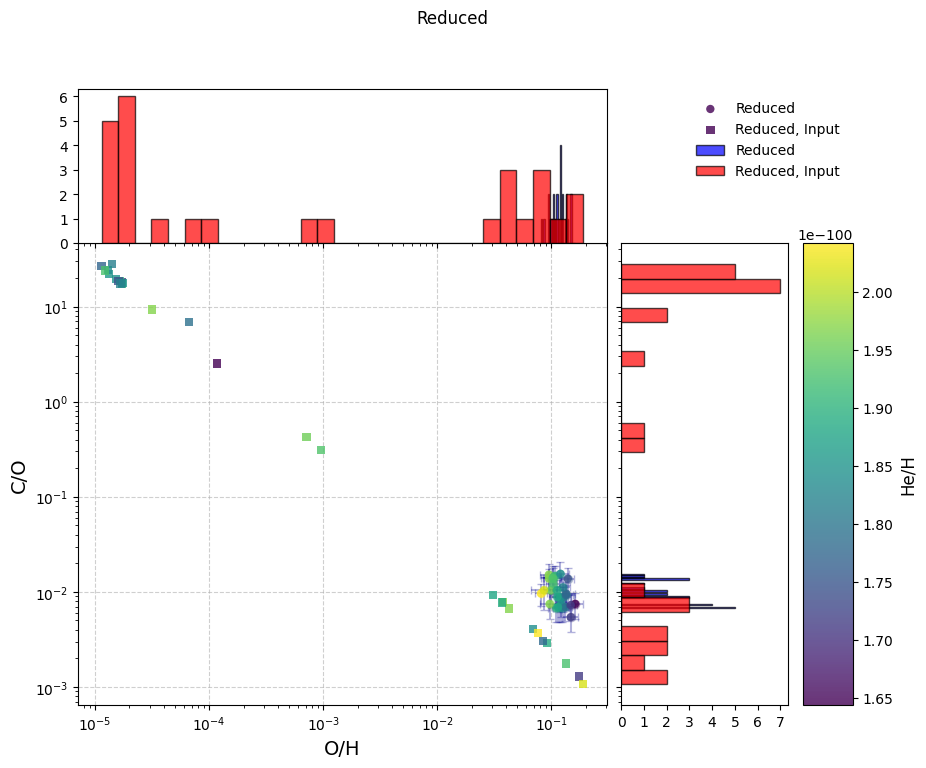

In [ ]:
fig, ax_s, ax_hx, ax_hy, ax_leg, global_norm = plot_scatter_with_histograms(
    out_targetlist[out_targetlist["Redox [Oxidized = 0, Reduced =1]"]==0], 
    x_key="O/H", y_key="C/O", 
    x_err_key="O/H_sigma", y_err_key="C/O_sigma", 
    color_key="He/H", 
    label="Oxidized", marker="o", cmap="viridis", hist_color="blue",
    err_color="darkblue", elinewidth=1.5, capsize=3, capthick=1, errorevery=1, err_alpha=0.3
)

plot_scatter_with_histograms(
    out_targetlist[out_targetlist["Redox [Oxidized = 0, Reduced =1]"]==0], "OHratio", "COratio",
        color_key="He/H", 
    label="Oxidized, Input", marker="s", cmap="viridis", hist_color="red",
    ax_scatter=ax_s, ax_hist_x=ax_hx, ax_hist_y=ax_hy, ax_legend=ax_leg, global_norm=global_norm, fig=fig)

fig.suptitle("Oxidized")

plt.show()

fig, ax_s, ax_hx, ax_hy, ax_leg, global_norm = plot_scatter_with_histograms(
    out_targetlist[out_targetlist["Redox [Oxidized = 0, Reduced =1]"]==1], 
    x_key="O/H", y_key="C/O", 
    x_err_key="O/H_sigma", y_err_key="C/O_sigma", 
    color_key="He/H", 
    label="Reduced", marker="o", cmap="viridis", hist_color="blue", alpha=0.8,
    err_color="darkblue", elinewidth=1.5, capsize=3, capthick=1, errorevery=1, err_alpha=0.3
)

plot_scatter_with_histograms(
    out_targetlist[out_targetlist["Redox [Oxidized = 0, Reduced =1]"]==1], "OHratio", "COratio",
        color_key="He/H", 
    label="Reduced, Input", marker="s", cmap="viridis", hist_color="red", alpha=0.8,
    ax_scatter=ax_s, ax_hist_x=ax_hx, ax_hist_y=ax_hy, ax_legend=ax_leg, global_norm=global_norm, fig=fig)

fig.suptitle("Reduced")

/tmp/ipykernel_2877269/4215962026.py:80: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_instance = plt.cm.get_cmap(cmap)
/tmp/ipykernel_2877269/4215962026.py:99: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax_scatter.scatter(


(<Figure size 1000x800 with 4 Axes>,
 <Axes: title={'center': 'Scatter Plot of O/H vs C/O'}, xlabel='O/H', ylabel='C/O'>,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 None)

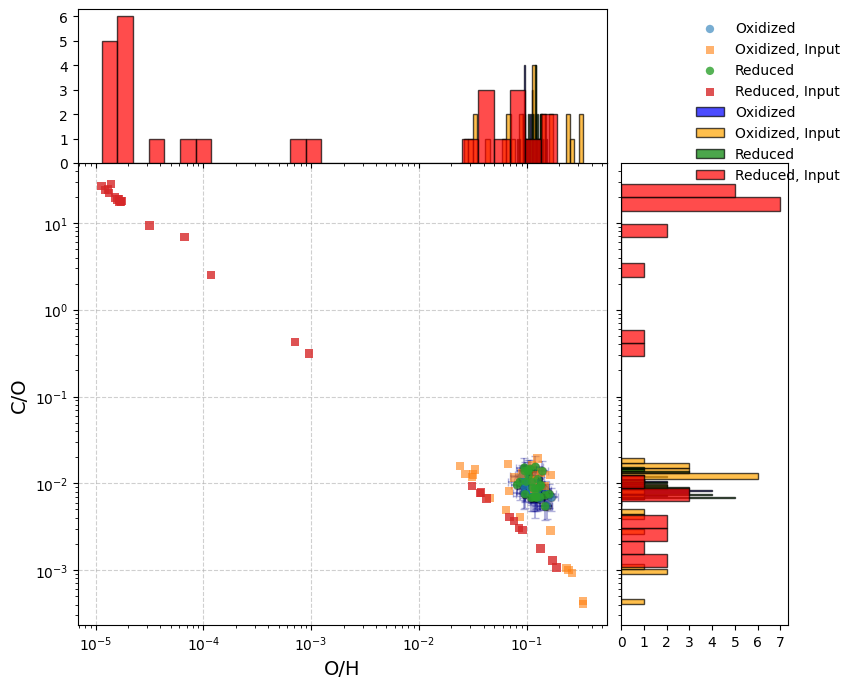

In [91]:
fig, ax_s, ax_hx, ax_hy, ax_leg, global_norm = plot_scatter_with_histograms(
    out_targetlist[out_targetlist["Redox [Oxidized = 0, Reduced =1]"]==0], 
    x_key="O/H", y_key="C/O", 
    x_err_key="O/H_sigma", y_err_key="C/O_sigma", 
    label="Oxidized", marker="o", cmap="viridis", hist_color="blue",
    err_color="darkblue", elinewidth=1.5, capsize=3, capthick=1, errorevery=1, err_alpha=0.3
)

plot_scatter_with_histograms(
    out_targetlist[out_targetlist["Redox [Oxidized = 0, Reduced =1]"]==0], "OHratio", "COratio",
    label="Oxidized, Input", marker="s", cmap="viridis", hist_color="orange",
    ax_scatter=ax_s, ax_hist_x=ax_hx, ax_hist_y=ax_hy, ax_legend=ax_leg, fig=fig)


plot_scatter_with_histograms(
    out_targetlist[out_targetlist["Redox [Oxidized = 0, Reduced =1]"]==1], 
    x_key="O/H", y_key="C/O", 
    x_err_key="O/H_sigma", y_err_key="C/O_sigma", 
    label="Reduced", marker="o", cmap="viridis", hist_color="green", alpha=0.8,
    err_color="darkblue", elinewidth=1.5, capsize=3, capthick=1, errorevery=1, err_alpha=0.3,
    ax_scatter=ax_s, ax_hist_x=ax_hx, ax_hist_y=ax_hy, ax_legend=ax_leg, fig=fig)


plot_scatter_with_histograms(
    out_targetlist[out_targetlist["Redox [Oxidized = 0, Reduced =1]"]==1], "OHratio", "COratio",
    label="Reduced, Input", marker="s", cmap="viridis", hist_color="red", alpha=0.8,
    ax_scatter=ax_s, ax_hist_x=ax_hx, ax_hist_y=ax_hy, ax_legend=ax_leg, fig=fig)

